In [ ]:
import sys, os

In [ ]:
#米田先生のコードを使わせてもらいました。

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/tmp'
if not os.path.exists(path):os.mkdir(path)
os.chdir(path)

try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.getcwd()
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name

    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    headers = {"User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:47.0) Gecko/20100101 Firefox/47.0"}
    request = urllib.request.Request(url_base+file_name, headers=headers)
    response = urllib.request.urlopen(request).read()
    with open(file_path, mode='wb') as f:
        f.write(response)
    print("Done")

def download_mnist():
    for v in key_file.values():
       _download(v)

def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")

    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")

    return data

def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])

    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1

    return T


def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNISTデータセットの読み込み
    Parameters
    ----------
    normalize : 画像のピクセル値を0.0~1.0に正規化する
    one_hot_label :
        one_hot_labelがTrueの場合、ラベルはone-hot配列として返す
        one-hot配列とは、たとえば[0,0,1,0,0,0,0,0,0,0]のような配列
    flatten : 画像を一次元配列に平にするかどうか
    Returns
    -------
    (訓練画像, 訓練ラベル), (テスト画像, テストラベル)
    """
    if not os.path.exists(save_file):
        init_mnist()

    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)

    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0

    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])


if __name__ == '__main__':
    init_mnist()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [ ]:
#各モジュールのインポート
path_common = '/content/drive/MyDrive/common'

import util
import functions
import gradient
import optimizer
import layers
import multi_layer_net
import multi_layer_net_extend
import trainer

Saving layers.py to layers.py


#6.1　パラメータの更新

##6.1. SGD

勾配の方向に従ってある一定距離を進み続けることで損失関数の最小値をもとめようという手法。勾配の方向が本来の最小値に向いていない関数など、使用する関数によっては非常に効率が悪いという問題点もある。

$$
W \leftarrow W - \eta 
\def\dd#1#2{\frac{\partial #1}{\partial #2}}
\dd{L}{W}
$$

In [ ]:
class SGD:
    #初期化　lr:学習計数(learning rate)
    def __init__(self, lr=0.01):
        self.lr = lr
    #
    #params['W1'], grads['W1']など、重みパラメータと勾配が格納されている
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

## 6.1.4　Momentum

物体が重力を受けて運動するように運動方程式を参考にSGDより効率的に最小値にたどり着くことを目的とした手法。

$$
v \leftarrow \alpha v - \eta 
\def\dd#1#2{\frac{\partial #1}{\partial #2}}
\dd{L}{W}
$$
\\
$$
W \leftarrow W + v
$$

In [ ]:
class Momentum:
    #初期化
    #lr:学習係数
    #momentum:上の式のαに当たる変数　物体が受ける摩擦や空気抵抗に対応する。
    #v:物体の速度にあたる変数
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        #最初の動作
        #vが空っぽなので、パラメータと同じ"構造"のデータを保持
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                #np.zeros_like()でvalの配列の要素を0で初期化した配列を生成
                #

        for key in params.keys():
          　#（6.3）に同じ
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            #（6.4）に同じ
            params[key] += self.v[key]

###6.1.5　AdaGrad

パラメータ一つ一つの学習係数をそれぞれ下げながら学習していくという手法。
行列の要素ごとの掛け算を*で表記しております。

$$
h \leftarrow h + 
\def\dd#1#2{\frac{\partial #1}{\partial #2}}
\dd{L}{W} * 
\def\dd#1#2{\frac{\partial #1}{\partial #2}}
\dd{L}{W}
$$
\
$$
W \leftarrow W - \eta \frac{1}{\sqrt{h}}
\def\dd#1#2{\frac{\partial #1}{\partial #2}}
\dd{L}{W}
$$

In [ ]:
class AdaGrad():
    #初期化
    #lr: 学習係数
    #h: 過去の勾配の二乗和
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    def update(self, params, grads):
        #最初の動作
        #
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for  key in params.keys():
            #（6.5）
            self.h[key] += grads[key] * grads[key]
            #（6.6）
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            #hの中に0があった場合のためにとても小さい値（1e-7）を加算している

##6.1.6　Adam

直感的には、MomentumとAdaGradを融合したような手法。
２つの利点を組み合わせることで、効率的にパラメータ空間を探索することが期待できる。また、ハイパーパラメータのバイアス補正が行われていることもこの手法の特徴である。

##6.1.8　各手法の比較

===========iteration:0===========
SGD:13.347797943762357
Momentum:15.321911438753837
AdaGrad:13.110618243502133
Adam:13.066824969687017


/content/multi_layer_net.py:543: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)
/content/multi_layer_net.py:543: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)
/content/multi_layer_net.py:150: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策


===========iteration:100===========
SGD:nan
Momentum:nan
AdaGrad:1.091852604147223
Adam:1.389044505111922
===========iteration:200===========
SGD:nan
Momentum:nan
AdaGrad:0.5630960579715973
Adam:1.031641622663526
===========iteration:300===========
SGD:nan
Momentum:nan
AdaGrad:0.15683259654533177
Adam:0.5727188368034587
===========iteration:400===========
SGD:nan
Momentum:nan
AdaGrad:0.39693330775156943
Adam:0.43398823604906195
===========iteration:500===========
SGD:nan
Momentum:nan
AdaGrad:0.36188755883799295
Adam:0.26265118047457814
===========iteration:600===========
SGD:nan
Momentum:nan
AdaGrad:0.3481197313846744
Adam:0.5358765727744548
===========iteration:700===========
SGD:nan
Momentum:nan
AdaGrad:0.2654329491476868
Adam:0.3741678365787331
===========iteration:800===========
SGD:nan
Momentum:nan
AdaGrad:0.08330455463548728
Adam:0.1560819817605507
===========iteration:900===========
SGD:nan
Momentum:nan
AdaGrad:0.2791782807121982
Adam:0.15884641210747272
===========iteration:100

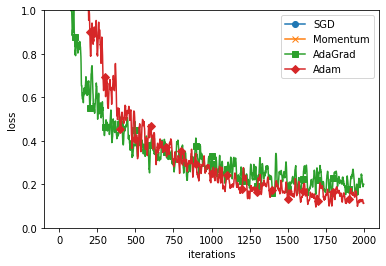

In [ ]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  
import matplotlib.pyplot as plt

from util import smooth_curve
from multi_layer_net import MultiLayerNet
from optimizer import *



# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

#6.2　重みの初期値

重みの初期値について

大事なポイント

*   なるべく小さい値にしたい
*   0とか0.01とか、均一な値にしてはいけない！


使う関数によって使い分けよう。

*   sigmoid関数やtanh関数なら -> Xavierの初期値

*   ReLu関数なら -> Heの初期値

##6.2.1　重みの初期値を全て0にしてはいけない理由



##6.2.2　隠れ層のアクティベーション分布
重みの初期値によって、活性関数の後の出力データ（アクティベーション）の分布がどのように変化するか簡単な実験を行う。

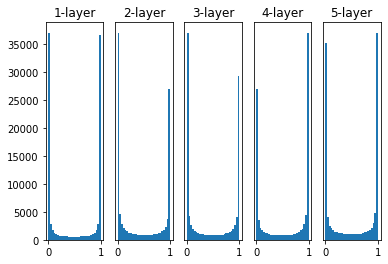

In [ ]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

###Xavierの初期値

平均0, 標準偏差1/√nの分布をWの初期値として扱う。

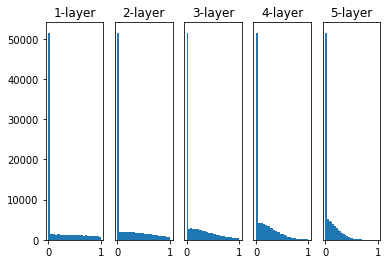

In [ ]:
x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)

    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

###Heの初期値

平均0, 標準偏差2/√nの分布をWの初期値として扱う。

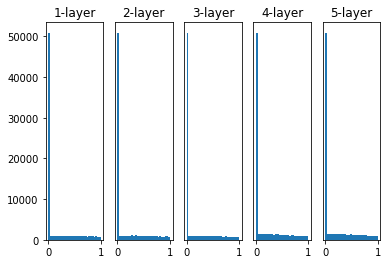

In [ ]:
x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) * np.sqrt(2)
    a = np.dot(x, w)

    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

#6.3　Batch Normalization

活性化関数の前か後に、入力データを平均0, 分散1のデータに変換してしまおうという処理。

$$
B = {x_{1}, x_{2}, ... , x_{m}}
$$というm個のミニバッチの入力データの集合に対する、$$平均値　\mu_{B}　、分散　\sigma_{B}^{2}$$
を求めた上で、
ミニバッチの入力データを、平均0、分散1のデータ分布にあるように標準化します。

$$
\mu_{B} \leftarrow \sum^m_{i=1}x_{i}
$$
$$
\sigma_{B}^{2} \leftarrow \frac{1}{m} \sum^m_{i=1}(x_{i} - \mu_{B})^{2}
$$
$$
\hat{x_{i}} \leftarrow \frac{x_{i} - \mu_{B}}{\sqrt{\sigma_{B}^{2}+\epsilon}}
$$

この処理を、活性化関数の前後どっちかに挿入することで、データ分布の偏りを減らすことができます。

$$
y_{i} \leftarrow \gamma\hat{x_{i}} + \beta 
$$

============== 1/16 ==============
epoch:0 | 0.099 - 0.118
epoch:1 | 0.097 - 0.114
epoch:2 | 0.097 - 0.126
epoch:3 | 0.097 - 0.148
epoch:4 | 0.097 - 0.178
epoch:5 | 0.097 - 0.198
epoch:6 | 0.097 - 0.227
epoch:7 | 0.097 - 0.254
epoch:8 | 0.097 - 0.264
epoch:9 | 0.097 - 0.282
epoch:10 | 0.097 - 0.298
epoch:11 | 0.097 - 0.31
epoch:12 | 0.097 - 0.324
epoch:13 | 0.097 - 0.343
epoch:14 | 0.097 - 0.359
epoch:15 | 0.097 - 0.37
epoch:16 | 0.097 - 0.373
epoch:17 | 0.097 - 0.373
epoch:18 | 0.097 - 0.392


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.404
============== 2/16 ==============
epoch:0 | 0.105 - 0.11


/content/drive/MyDrive/tmp/multi_layer_net_extend.py:521: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/tmp/multi_layer_net_extend.py:521: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/tmp/multi_layer_net_extend.py:124: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策


epoch:1 | 0.097 - 0.123
epoch:2 | 0.097 - 0.123
epoch:3 | 0.097 - 0.123
epoch:4 | 0.097 - 0.142
epoch:5 | 0.097 - 0.147
epoch:6 | 0.097 - 0.177
epoch:7 | 0.097 - 0.196
epoch:8 | 0.097 - 0.229
epoch:9 | 0.097 - 0.246
epoch:10 | 0.097 - 0.277
epoch:11 | 0.097 - 0.304
epoch:12 | 0.097 - 0.325
epoch:13 | 0.097 - 0.352
epoch:14 | 0.097 - 0.37
epoch:15 | 0.097 - 0.397
epoch:16 | 0.097 - 0.412
epoch:17 | 0.097 - 0.425
epoch:18 | 0.097 - 0.447


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.451
============== 3/16 ==============
epoch:0 | 0.116 - 0.113


/content/drive/MyDrive/tmp/multi_layer_net_extend.py:521: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/tmp/multi_layer_net_extend.py:521: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.13
epoch:2 | 0.097 - 0.153
epoch:3 | 0.097 - 0.181
epoch:4 | 0.097 - 0.206
epoch:5 | 0.097 - 0.243
epoch:6 | 0.097 - 0.278
epoch:7 | 0.097 - 0.305
epoch:8 | 0.097 - 0.339
epoch:9 | 0.097 - 0.368
epoch:10 | 0.097 - 0.401
epoch:11 | 0.097 - 0.432
epoch:12 | 0.097 - 0.457
epoch:13 | 0.097 - 0.49
epoch:14 | 0.097 - 0.506
epoch:15 | 0.097 - 0.536
epoch:16 | 0.097 - 0.559
epoch:17 | 0.097 - 0.579
epoch:18 | 0.097 - 0.595


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.6
============== 4/16 ==============
epoch:0 | 0.117 - 0.097
epoch:1 | 0.097 - 0.089
epoch:2 | 0.097 - 0.133
epoch:3 | 0.097 - 0.21
epoch:4 | 0.097 - 0.266
epoch:5 | 0.097 - 0.351
epoch:6 | 0.097 - 0.405
epoch:7 | 0.097 - 0.456
epoch:8 | 0.097 - 0.505
epoch:9 | 0.097 - 0.546
epoch:10 | 0.097 - 0.59
epoch:11 | 0.097 - 0.627
epoch:12 | 0.097 - 0.645
epoch:13 | 0.097 - 0.668
epoch:14 | 0.097 - 0.7
epoch:15 | 0.097 - 0.708
epoch:16 | 0.097 - 0.731
epoch:17 | 0.097 - 0.759
epoch:18 | 0.097 - 0.775
epoch:19 | 0.097 - 0.793


No handles with labels found to put in legend.


============== 5/16 ==============
epoch:0 | 0.094 - 0.078
epoch:1 | 0.376 - 0.081
epoch:2 | 0.568 - 0.215
epoch:3 | 0.682 - 0.363
epoch:4 | 0.75 - 0.465
epoch:5 | 0.784 - 0.554
epoch:6 | 0.829 - 0.602
epoch:7 | 0.864 - 0.649
epoch:8 | 0.893 - 0.702
epoch:9 | 0.903 - 0.731
epoch:10 | 0.925 - 0.754
epoch:11 | 0.941 - 0.783
epoch:12 | 0.947 - 0.802
epoch:13 | 0.965 - 0.816
epoch:14 | 0.975 - 0.823
epoch:15 | 0.981 - 0.836
epoch:16 | 0.985 - 0.844
epoch:17 | 0.987 - 0.858
epoch:18 | 0.993 - 0.867


No handles with labels found to put in legend.


epoch:19 | 0.996 - 0.871
============== 6/16 ==============
epoch:0 | 0.109 - 0.095
epoch:1 | 0.374 - 0.188
epoch:2 | 0.6 - 0.424
epoch:3 | 0.671 - 0.564
epoch:4 | 0.672 - 0.655
epoch:5 | 0.737 - 0.715
epoch:6 | 0.828 - 0.753
epoch:7 | 0.703 - 0.789
epoch:8 | 0.816 - 0.815
epoch:9 | 0.87 - 0.825
epoch:10 | 0.879 - 0.839
epoch:11 | 0.872 - 0.853
epoch:12 | 0.82 - 0.864
epoch:13 | 0.92 - 0.874
epoch:14 | 0.933 - 0.889
epoch:15 | 0.931 - 0.905
epoch:16 | 0.936 - 0.917
epoch:17 | 0.946 - 0.93
epoch:18 | 0.958 - 0.942


No handles with labels found to put in legend.


epoch:19 | 0.96 - 0.943
============== 7/16 ==============
epoch:0 | 0.07 - 0.093
epoch:1 | 0.085 - 0.205
epoch:2 | 0.122 - 0.574
epoch:3 | 0.141 - 0.709
epoch:4 | 0.164 - 0.761
epoch:5 | 0.177 - 0.791
epoch:6 | 0.182 - 0.826
epoch:7 | 0.193 - 0.848
epoch:8 | 0.193 - 0.876
epoch:9 | 0.185 - 0.905
epoch:10 | 0.209 - 0.926
epoch:11 | 0.233 - 0.94
epoch:12 | 0.234 - 0.951
epoch:13 | 0.229 - 0.956
epoch:14 | 0.231 - 0.968
epoch:15 | 0.25 - 0.973
epoch:16 | 0.247 - 0.976
epoch:17 | 0.229 - 0.981
epoch:18 | 0.243 - 0.986


No handles with labels found to put in legend.


epoch:19 | 0.273 - 0.986
============== 8/16 ==============
epoch:0 | 0.094 - 0.073
epoch:1 | 0.116 - 0.379
epoch:2 | 0.116 - 0.699
epoch:3 | 0.116 - 0.802
epoch:4 | 0.116 - 0.843
epoch:5 | 0.141 - 0.875
epoch:6 | 0.117 - 0.913
epoch:7 | 0.117 - 0.938
epoch:8 | 0.117 - 0.954
epoch:9 | 0.117 - 0.968
epoch:10 | 0.117 - 0.98
epoch:11 | 0.117 - 0.984
epoch:12 | 0.117 - 0.989
epoch:13 | 0.117 - 0.99
epoch:14 | 0.117 - 0.994
epoch:15 | 0.117 - 0.996
epoch:16 | 0.117 - 0.996
epoch:17 | 0.117 - 0.996
epoch:18 | 0.133 - 0.997


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.998
============== 9/16 ==============
epoch:0 | 0.1 - 0.151
epoch:1 | 0.117 - 0.513
epoch:2 | 0.117 - 0.666
epoch:3 | 0.117 - 0.75
epoch:4 | 0.117 - 0.824
epoch:5 | 0.117 - 0.86
epoch:6 | 0.117 - 0.877
epoch:7 | 0.117 - 0.892
epoch:8 | 0.117 - 0.895
epoch:9 | 0.117 - 0.906
epoch:10 | 0.117 - 0.948
epoch:11 | 0.117 - 0.991
epoch:12 | 0.117 - 0.995
epoch:13 | 0.117 - 0.997
epoch:14 | 0.117 - 0.998
epoch:15 | 0.117 - 0.998
epoch:16 | 0.117 - 0.998
epoch:17 | 0.117 - 1.0
epoch:18 | 0.117 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.117 - 1.0
============== 10/16 ==============
epoch:0 | 0.117 - 0.151
epoch:1 | 0.117 - 0.588
epoch:2 | 0.117 - 0.716
epoch:3 | 0.117 - 0.744
epoch:4 | 0.117 - 0.808
epoch:5 | 0.117 - 0.837
epoch:6 | 0.116 - 0.868
epoch:7 | 0.117 - 0.886
epoch:8 | 0.117 - 0.899
epoch:9 | 0.116 - 0.93
epoch:10 | 0.116 - 0.825
epoch:11 | 0.116 - 0.865
epoch:12 | 0.116 - 0.982
epoch:13 | 0.116 - 0.989
epoch:14 | 0.116 - 0.991
epoch:15 | 0.116 - 0.994
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.997
epoch:18 | 0.117 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.998
============== 11/16 ==============
epoch:0 | 0.105 - 0.197
epoch:1 | 0.117 - 0.571
epoch:2 | 0.117 - 0.65
epoch:3 | 0.117 - 0.769
epoch:4 | 0.117 - 0.813
epoch:5 | 0.116 - 0.86
epoch:6 | 0.116 - 0.869
epoch:7 | 0.116 - 0.875
epoch:8 | 0.117 - 0.89
epoch:9 | 0.117 - 0.84
epoch:10 | 0.116 - 0.83
epoch:11 | 0.116 - 0.891
epoch:12 | 0.116 - 0.891
epoch:13 | 0.117 - 0.978
epoch:14 | 0.117 - 0.985
epoch:15 | 0.117 - 0.992
epoch:16 | 0.117 - 0.996
epoch:17 | 0.117 - 0.951
epoch:18 | 0.116 - 0.965
epoch:19 | 0.116 - 0.996


No handles with labels found to put in legend.


============== 12/16 ==============
epoch:0 | 0.117 - 0.224
epoch:1 | 0.117 - 0.619
epoch:2 | 0.117 - 0.506
epoch:3 | 0.117 - 0.687
epoch:4 | 0.117 - 0.741
epoch:5 | 0.117 - 0.775
epoch:6 | 0.117 - 0.765
epoch:7 | 0.117 - 0.854
epoch:8 | 0.117 - 0.876
epoch:9 | 0.117 - 0.847
epoch:10 | 0.117 - 0.861
epoch:11 | 0.117 - 0.886
epoch:12 | 0.117 - 0.878
epoch:13 | 0.117 - 0.894
epoch:14 | 0.117 - 0.884
epoch:15 | 0.117 - 0.892
epoch:16 | 0.117 - 0.9
epoch:17 | 0.116 - 0.895
epoch:18 | 0.116 - 0.9
epoch:19 | 0.116 - 0.898


No handles with labels found to put in legend.


============== 13/16 ==============
epoch:0 | 0.099 - 0.159
epoch:1 | 0.097 - 0.448
epoch:2 | 0.116 - 0.649
epoch:3 | 0.116 - 0.678
epoch:4 | 0.116 - 0.681
epoch:5 | 0.116 - 0.686
epoch:6 | 0.116 - 0.69
epoch:7 | 0.116 - 0.702
epoch:8 | 0.116 - 0.707
epoch:9 | 0.116 - 0.704
epoch:10 | 0.116 - 0.707
epoch:11 | 0.116 - 0.711
epoch:12 | 0.116 - 0.71
epoch:13 | 0.116 - 0.717
epoch:14 | 0.116 - 0.715
epoch:15 | 0.116 - 0.714
epoch:16 | 0.116 - 0.7
epoch:17 | 0.116 - 0.723
epoch:18 | 0.116 - 0.767


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.738
============== 14/16 ==============
epoch:0 | 0.117 - 0.157
epoch:1 | 0.117 - 0.436
epoch:2 | 0.117 - 0.477
epoch:3 | 0.117 - 0.39
epoch:4 | 0.117 - 0.504
epoch:5 | 0.117 - 0.555
epoch:6 | 0.117 - 0.556
epoch:7 | 0.117 - 0.578
epoch:8 | 0.117 - 0.577
epoch:9 | 0.117 - 0.589
epoch:10 | 0.117 - 0.603
epoch:11 | 0.117 - 0.606
epoch:12 | 0.117 - 0.596
epoch:13 | 0.117 - 0.585
epoch:14 | 0.117 - 0.605
epoch:15 | 0.117 - 0.585
epoch:16 | 0.117 - 0.599
epoch:17 | 0.117 - 0.606
epoch:18 | 0.117 - 0.617


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.617
============== 15/16 ==============
epoch:0 | 0.117 - 0.123
epoch:1 | 0.117 - 0.449
epoch:2 | 0.117 - 0.477
epoch:3 | 0.117 - 0.51
epoch:4 | 0.117 - 0.516
epoch:5 | 0.117 - 0.531
epoch:6 | 0.117 - 0.522
epoch:7 | 0.117 - 0.531
epoch:8 | 0.117 - 0.56
epoch:9 | 0.117 - 0.525
epoch:10 | 0.117 - 0.518
epoch:11 | 0.117 - 0.524
epoch:12 | 0.117 - 0.599
epoch:13 | 0.117 - 0.614
epoch:14 | 0.117 - 0.625
epoch:15 | 0.117 - 0.669
epoch:16 | 0.117 - 0.683
epoch:17 | 0.117 - 0.683
epoch:18 | 0.117 - 0.69


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.66
============== 16/16 ==============
epoch:0 | 0.117 - 0.174
epoch:1 | 0.117 - 0.117
epoch:2 | 0.117 - 0.256
epoch:3 | 0.117 - 0.318
epoch:4 | 0.117 - 0.397
epoch:5 | 0.117 - 0.385
epoch:6 | 0.117 - 0.41
epoch:7 | 0.117 - 0.418
epoch:8 | 0.117 - 0.418
epoch:9 | 0.117 - 0.42
epoch:10 | 0.117 - 0.414
epoch:11 | 0.117 - 0.427
epoch:12 | 0.117 - 0.418
epoch:13 | 0.117 - 0.428
epoch:14 | 0.117 - 0.429
epoch:15 | 0.117 - 0.422
epoch:16 | 0.117 - 0.423
epoch:17 | 0.117 - 0.425
epoch:18 | 0.117 - 0.425
epoch:19 | 0.117 - 0.43


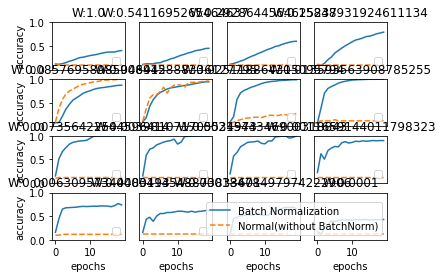

In [ ]:
# batch_norm_test
import matplotlib.pyplot as plt
from multi_layer_net_extend import MultiLayerNetExtend
from optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

#6.4　正則化

###過学習

過学習とは、訓練データに適応しすぎてしまうことで、訓練データに含まれないデータ（例えば、テストデータ）には対応できなくなってしまう状態を指す。

過学習が起きる原因として主に次の２つが挙げられる。

*   訓練データが少ない。
*   パラメータを大量に持ち、表現力が高いモデルである。



###Weight Decay
重みパラメータが大きな値を取ることによって、過学習が発生することがあることから、逆に重みパラメータが大きな値を取ることにペナルティを課すことで過学習を抑制しようという手法。

epoch:0, train acc:0.09666666666666666, test acc:0.1028
epoch:1, train acc:0.11333333333333333, test acc:0.098
epoch:2, train acc:0.11333333333333333, test acc:0.098


/content/drive/MyDrive/tmp/multi_layer_net.py:150: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策


epoch:3, train acc:0.11333333333333333, test acc:0.098
epoch:4, train acc:0.11333333333333333, test acc:0.098
epoch:5, train acc:0.11333333333333333, test acc:0.098
epoch:6, train acc:0.11333333333333333, test acc:0.098
epoch:7, train acc:0.11333333333333333, test acc:0.098
epoch:8, train acc:0.11333333333333333, test acc:0.098
epoch:9, train acc:0.11333333333333333, test acc:0.098
epoch:10, train acc:0.11333333333333333, test acc:0.098
epoch:11, train acc:0.11333333333333333, test acc:0.098
epoch:12, train acc:0.11333333333333333, test acc:0.098
epoch:13, train acc:0.11333333333333333, test acc:0.098
epoch:14, train acc:0.11333333333333333, test acc:0.098
epoch:15, train acc:0.11333333333333333, test acc:0.098
epoch:16, train acc:0.11333333333333333, test acc:0.098
epoch:17, train acc:0.11333333333333333, test acc:0.098
epoch:18, train acc:0.11333333333333333, test acc:0.098
epoch:19, train acc:0.11333333333333333, test acc:0.098
epoch:20, train acc:0.11333333333333333, test acc:0.098

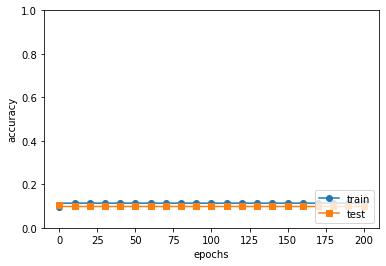

In [ ]:
# 
import numpy as np
import matplotlib.pyplot as plt
from multi_layer_net import MultiLayerNet
from optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

###Dropout

ニューロンをランダムに消去しながら学習する手法
訓練時に隠れ層のニューロンをランダムに選び出し、その選び出したニューロンを消去する。
訓練時は、データが流れるたびに消去するニューロンを選択する。そして、テスト時には、全てのニューロンの信号を伝達するが、各ニューロンの出力に対して、訓練時に消去した割合を乗算して出力する。

train loss:2.3048630043224207
=== epoch:1, train acc:0.12, test acc:0.099 ===
train loss:2.3203986489223927
train loss:2.3144749625545327
train loss:2.324429109258106
=== epoch:2, train acc:0.12333333333333334, test acc:0.0981 ===
train loss:2.3063309844000135
train loss:2.313880084565047
train loss:2.31482509301002
=== epoch:3, train acc:0.12333333333333334, test acc:0.099 ===
train loss:2.323630902834766
train loss:2.302488706327086
train loss:2.2985356353552238
=== epoch:4, train acc:0.12333333333333334, test acc:0.0993 ===
train loss:2.3085371729496806
train loss:2.3093699119797937
train loss:2.3167247782791103
=== epoch:5, train acc:0.12333333333333334, test acc:0.0991 ===
train loss:2.3088661526763268
train loss:2.3116504230169634
train loss:2.3029272433338477
=== epoch:6, train acc:0.12333333333333334, test acc:0.0992 ===
train loss:2.29374159915032
train loss:2.2999917410154764
train loss:2.3083132844319754
=== epoch:7, train acc:0.11666666666666667, test acc:0.0997 ===
train l

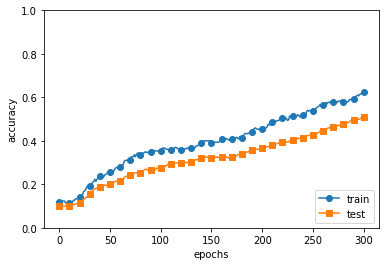

In [ ]:
# coding: utf-8
from multi_layer_net_extend import MultiLayerNetExtend
from trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#6.5　ハイパーパラメーター

ニューラルネットワークには、重みやバイアスといったパラメータが存在するが、それとは別に、
各層のニューロンの数やバッチサイズ、パラメータ更新の時の学習係数やWeight decayなどのハイパーパラメータと呼ばれるパラメータが存在する。こちらで適切な値に設定することで性能の良いモデルを作ることができる。



###6.5.1　ハイパーパラメータの検証
基本的には、ハイパーパラメータの適切な値は、訓練データを使って検証していくことになるが、ここで検証用に別途作成した検証データを使用する必要がある。

###6.5.2　ハイパーパラメータの最適化
ハイパーパラメータの最適化には、ざっくりと「良い値」が存在する範囲を徐々に絞り込んでいくという方法で行う。


0.   ハイパーパラメータの範囲を設定する
1.   設定されたハイパーパラメータの範囲からランダムにサンプリングする。
2. 　1.で設定サンプリングされたハイパーパラメータの値を使用して学習を行い、検証データで認識制度を評価する。（ただしエポックは小さく設定）。
3. 　1. と2. をある回数（100回など）繰り返し、それらの認識制度の結果からハイパーパラメータの範囲を狭める。


###6.5.3　ハイパーパラメータの実装

val acc:0.49 | lr:0.0004966460553494392, weight decay:7.34528815963478e-06
val acc:0.32 | lr:1.4420495175234086e-05, weight decay:2.7025537264873915e-06
val acc:0.17 | lr:0.0029565751956427983, weight decay:3.3040157068140185e-08
val acc:0.25 | lr:1.4127748996849152e-06, weight decay:1.3856331606999814e-08
val acc:0.4 | lr:4.115784766401391e-05, weight decay:7.821610394978989e-07
val acc:0.31 | lr:4.894865076902835e-06, weight decay:1.713565877763184e-07
val acc:0.21 | lr:7.415558295496138e-06, weight decay:1.9942471183468375e-06
val acc:0.17 | lr:2.8810579977392114e-06, weight decay:1.1464186194279686e-08
val acc:0.48 | lr:0.0006055749537953167, weight decay:9.478913098477036e-08
val acc:0.42 | lr:0.0002364310289263953, weight decay:2.651536511885076e-06
val acc:0.6 | lr:0.0018081608609988805, weight decay:2.1109325390909386e-08
val acc:0.42 | lr:0.0010518606718247746, weight decay:1.199797299647167e-06
val acc:0.17 | lr:0.00953098763728145, weight decay:7.724640044214556e-06
val acc:

/content/drive/MyDrive/tmp/multi_layer_net.py:543: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)


val acc:0.17 | lr:0.0037223636825707575, weight decay:7.420452515220303e-06
val acc:0.4 | lr:0.00015675074250032288, weight decay:1.8037457811856728e-07
val acc:0.15 | lr:4.192172797823942e-06, weight decay:2.610151058418984e-05
val acc:0.18 | lr:2.5120619376581365e-06, weight decay:3.639987770928372e-05
val acc:0.33 | lr:3.735726957494278e-05, weight decay:4.495695843942644e-07
val acc:0.42 | lr:0.001354930599635538, weight decay:1.4474553820160986e-05
val acc:0.17 | lr:0.004160618482118059, weight decay:4.8370984115253765e-05
val acc:0.2 | lr:1.7502128904731451e-06, weight decay:4.528992255779563e-07
val acc:0.11 | lr:3.5097553881087025e-06, weight decay:3.542891394048901e-08
val acc:0.43 | lr:0.0008004401686815278, weight decay:7.3141891205388406e-06
val acc:0.39 | lr:6.034841253607259e-05, weight decay:1.677994161627851e-08
val acc:0.42 | lr:4.5440556153547896e-05, weight decay:8.252721413936308e-08
val acc:0.17 | lr:0.005453322108821175, weight decay:5.832374285849697e-06
val acc:

/content/drive/MyDrive/tmp/multi_layer_net.py:150: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策


val acc:0.17 | lr:0.0049833389618368544, weight decay:7.372073077150032e-06
val acc:0.46 | lr:3.1001014890186696e-05, weight decay:1.8533163769286857e-08
val acc:0.25 | lr:3.407448520856529e-06, weight decay:9.32474163589113e-05
val acc:0.33 | lr:1.661695045246996e-05, weight decay:1.0972548329984016e-07
val acc:0.46 | lr:0.000977092283559977, weight decay:8.788474320561895e-06
val acc:0.53 | lr:0.00264069385632819, weight decay:6.305242021398753e-06
val acc:0.31 | lr:4.8223818267875675e-06, weight decay:1.2413782675594676e-07
val acc:0.19 | lr:1.7593538140005057e-06, weight decay:1.7262404701865443e-07
val acc:0.54 | lr:0.00023724151994177048, weight decay:1.1257982777091846e-05
val acc:0.44 | lr:0.001492938093996517, weight decay:1.0292487391364165e-08
val acc:0.3 | lr:4.756131352727066e-06, weight decay:2.819453923643989e-07


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


val acc:0.17 | lr:0.004769247235024551, weight decay:6.447034663144983e-07
val acc:0.17 | lr:0.005342494945938504, weight decay:1.5486524908223512e-06
val acc:0.15 | lr:2.0842889764914235e-06, weight decay:1.0901808502494777e-05
val acc:0.39 | lr:6.275357088337443e-05, weight decay:2.5056934242321106e-06
val acc:0.42 | lr:0.0001503302481722119, weight decay:3.806761236924009e-08
val acc:0.19 | lr:6.602005342212329e-06, weight decay:1.8655384216212062e-08
val acc:0.17 | lr:0.00840834192461375, weight decay:4.5359152295669363e-07
val acc:0.5 | lr:0.0005646187557325036, weight decay:2.710710353018604e-08
val acc:0.21 | lr:7.194733501644802e-06, weight decay:4.04244734137827e-06
val acc:0.4 | lr:0.0001339656019200952, weight decay:9.145081286524161e-06
val acc:0.38 | lr:6.933740524693295e-05, weight decay:1.066032116118201e-05
val acc:0.5 | lr:0.00018854914193550782, weight decay:2.6481075413149486e-07
val acc:0.53 | lr:0.0010334584151893776, weight decay:1.2483386077591786e-06
val acc:0.1

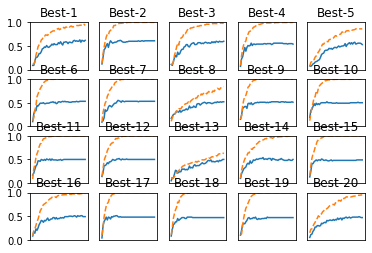

In [ ]:
# hyperperameter/py
from multi_layer_net import MultiLayerNet
from util import shuffle_dataset
from trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定===============
    # Weight dacay 係数を10^(-8) ～ 10^(-4)の範囲に設定
    weight_decay = 10 ** np.random.uniform(-8, -4)
    #学習係数を10^(-6) ～ 10^(-2)の範囲に設定
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

#出力
for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()